In [1]:
import torch
import torchvision
import cv2

In [2]:
import os
import numpy as np
import json
import random 
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [3]:
import detectron2

存改變尺度和改變圖片


In [4]:
def get_resize_ratio(file_path):
    #read image to resize
    file_path = file_path[:-5] + ".png"
    image = cv2.imread(file_path)
    #resize to 1000*1000
    resized_image = cv2.resize(image, (480, 480))  
    #get resize ratio      
    resize_ratio = resized_image.shape[0] / image.shape[0]
    #write to file
    cv2.imwrite(file_path, resized_image)
    return resize_ratio



存每個json的資料並回傳改變後的尺寸回json中

In [5]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for i, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)

        #要處理每場圖片的大小 要resize
        resize_ratio = get_resize_ratio(json_file)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        record = {}
        filename = os.path.join(directory, img_anns["imagePath"])
        record['image_id'] = i
        record["file_name"] = filename
        record["height"] = 480
        record["width"] = 480
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] *resize_ratio for a in anno['points']] # x coord
            py = [a[1] *resize_ratio for a in anno['points']] # y-coord
            for i, a in enumerate(anno['points']):
                anno['points'][i] = (a[0] * resize_ratio, a[1] * resize_ratio)
            with open(json_file, 'w') as f:
                json.dump(img_anns, f)
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                #"segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
    

In [6]:
classes = ['powder_uncover', 'powder_uneven', 'scratch']

data_path = '/Users/david/Desktop/DIP_FINAL/class_data/Try/'


for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")



In [7]:
print(type(microcontroller_metadata))
MetadataCatalog.get("category_" + d).set(thing_classes=classes)

<class 'detectron2.data.catalog.Metadata'>


namespace(name='category_test',
          thing_classes=['powder_uncover', 'powder_uneven', 'scratch'])

In [8]:
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer


In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = "outputModels1"

In [12]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(True)

[01/10 08:03:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
#trainer.train()

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0029999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

In [14]:
cfg.DATASETS.TEST = ("category_test", )
predictor = DefaultPredictor(cfg)

[01/10 08:04:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from outputModels1/model_0029999.pth ...


In [13]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

# 計算ＩＯＵ

### 計算兩列表相似度

In [12]:
def euclid(v1, v2):
    distance = 0
    for i in range(len(v1)):
        distance += (v1[i] - v2[i])**2
    return distance / len(v1)

In [13]:
def calculate_similarity_gt(box1, box2):#ps比out_iou長 存回ps 若相反則import時倒轉
    new_box = []
    for index2, box2_item in enumerate(box2):
        similarity = []
        for index1, box1_item in enumerate(box1):
            similarity.append(euclid(box2_item, box1_item))
        new_box.append(box1[similarity.index(min(similarity))])
    new_box = [tuple(b) for b in new_box]
    return list(set(new_box))

'''
if(len(ps) > len(list_of_lists)):
    ps = calculate_similarity_gt(ps, list_of_lists)
else:
    list_of_lists = calculate_similarity_gt(list_of_lists, ps)


#print(ps)
print(list_of_lists)
'''

'\nif(len(ps) > len(list_of_lists)):\n    ps = calculate_similarity_gt(ps, list_of_lists)\nelse:\n    list_of_lists = calculate_similarity_gt(list_of_lists, ps)\n\n\n#print(ps)\nprint(list_of_lists)\n'

In [14]:
def calculate_iou(box1, box2):
    # Calculate area of each bounding box
    x1, y1, x2, y2 = box1
    box1_area = abs((x2 - x1) * (y2 - y1))
    x1, y1, x2, y2 = box2
    box2_area = abs((x2 - x1) * (y2 - y1))
    # Calculate intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    #if x1 < x2 and y1 < y2:
    intersection_area = abs((x2 - x1) * (y2 - y1))
    #else:
    #intersection_area = np.abs(intersection_area)
    #print(intersection_area)
    # Calculate union area
    
    union_area = box1_area + box2_area - intersection_area
    #print(f"box1{box1_area}")
    #print(f"box2{box2_area}")
    #print(f"union{union_area}")
    #print(f"intertection{intersection_area}")
    if(union_area < 0):return 0

    # Return IOU
    return intersection_area / union_area



#for i, b1 in enumerate(out_iou):
#    b2 = ps[i]
#    iou = calculate_iou(b1, b2)
#    print(f'IOU for boxes {i}: {iou}')



In [15]:
def IOU(directory):
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        img = cv2.imread(json_file[:-5] + '.png')
        outputs = predictor(img)#predicted outputs
        with open(json_file, "r") as f:#get real json's coordinate
            data = json.load(f)
            annos = data["shapes"]
            ps = []
            for anno in annos:
                    px = [a[0] for a in anno['points']] # x coord
                    py = [a[1] for a in anno['points']] # y-coord
                    poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
                    poly = [p for x in poly for p in x]
                    ps.append(poly)
        print(json_file)
        #print(ps)
        ps = sorted(ps, key=lambda x: x[0])#get real json's coordinate
        out_iou = outputs["instances"].pred_boxes.tensor.cpu()#sort cuz it's in wrong order
        #print(out_iou)
        list_of_lists = [t.tolist() for t in out_iou]
        list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
        
        
        
        iou = 0
        if(len(ps) < len(list_of_lists)):
            list_of_lists = calculate_similarity_gt(list_of_lists, ps)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(list_of_lists):
                b2 = ps[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(list_of_lists)
        elif(len(ps) > len(list_of_lists)):
            ps = calculate_similarity_gt(ps, list_of_lists)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)
        else:
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b2, b1)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)

        if(iou > 1): iou = 1#有些bug>1我抓不到
            
        print(iou)
        #print(list_of_lists)
        #print(ps)

In [28]:
def IOU_file(filename):
        cfg = get_cfg()
        microcontroller_metadata = { "name": "category_test", "thing_classes": ["powder_uncover", "powder_uneven", "scratch"]}
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/outputModels1/model_final.pth"
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.DEVICE = 'cpu'
        cfg.DATASETS.TEST = ("category_test", )
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        predictor = DefaultPredictor(cfg) 
        json_file = filename
        json_file = json_file.replace("label", "image")
        img = cv2.imread(json_file[:-5] + '.png')
        outputs = predictor(img)#predicted outputs
        json_file = json_file.replace("image", "label")
        with open(json_file, "r") as f:#get real json's coordinate
            data = json.load(f)
            annos = data["shapes"]
            ps = []
            for anno in annos:
                    px = [a[0] for a in anno['points']] # x coord
                    py = [a[1] for a in anno['points']] # y-coord
                    poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
                    poly = [p for x in poly for p in x]
                    ps.append(poly)
        #print(ps)
        ps = sorted(ps, key=lambda x: x[0])#get real json's coordinate
        out_iou = outputs["instances"].pred_boxes.tensor.cpu()#sort cuz it's in wrong order
        #print(out_iou)
        list_of_lists = [t.tolist() for t in out_iou]
        list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
        
        
        
        iou = 0
        if(len(ps) < len(list_of_lists)):
            list_of_lists = calculate_similarity_gt(list_of_lists, ps)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(list_of_lists):
                b2 = ps[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(list_of_lists)
        elif(len(ps) > len(list_of_lists)):
            ps = calculate_similarity_gt(ps, list_of_lists)
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b1, b2)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)
        else:
            list_of_lists = sorted(list_of_lists, key=lambda x:x[0])
            ps = sorted(ps, key=lambda x: x[0])
            for i, b1 in enumerate(ps):
                b2 = list_of_lists[i]
                iou += calculate_iou(b2, b1)
                #print(f'IOU for boxes {i}: {iou}')
            iou = iou / len(ps)

        if(iou > 1): iou = 1#有些bug>1我抓不到
            
        return iou
        #print(list_of_lists)
        #print(ps)

In [33]:
IOU_file("/Users/david/Desktop/DIP_final/class_data/Try/gui_test/label/Converted_ 0003.json")

0.9513330813133467

# call IOU

In [19]:
data_path = '/Users/david/Desktop/DIP_final/class_data/Try/gui_test/image'
d = 'fuck'

DatasetCatalog.register(
    "category_" + d, 
    lambda d=d: get_data_dicts(data_path, classes)
)

In [21]:
import os
import shutil
import json

# 定義資料夾路徑
data_path = '/Users/david/Desktop/DIP_final/powder_uncover/'
output_path = '/Users/david/Desktop/DIP_final/powder_uncover/mix'
# 如果輸出資料夾已經存在，則不進行合併
if not os.path.exists(output_path):
# 讀取資料夾下的所有文件
    image_files = os.listdir(os.path.join(data_path, 'image'))
    label_files = os.listdir(os.path.join(data_path, 'label'))

    # 將 image 和 label 混在一起
    data = []
    for image_file in image_files:
        if image_file.endswith('.png'):
            data.append(('image', image_file))

    for label_file in label_files:
        if label_file.endswith('.json'):
            with open(os.path.join(data_path, 'label', label_file)) as f:
                label = json.load(f)
            data.append(('label', label))

    # 將混合後的檔案存到新的資料夾內
    for type, file in data:
        if type == 'image':
            shutil.copy(os.path.join(data_path, 'image', file), output_path)
        elif type == 'label':
            with open(os.path.join(output_path, file['name']), 'w') as f:
                json.dump(file, f)


KeyError: 'name'

# Evaluate AP50

In [15]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
evaluator = COCOEvaluator("category_test", cfg, False, output_dir="/Users/david/Desktop/DIP_final/output")
val_loader = build_detection_test_loader(cfg, "category_test")
ap50 = inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [01/10 08:04:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/10 08:04:13 d2.evaluation.coco_evaluation]: Trying to convert 'category_test' to COCO format ...
WARNING [01/10 08:04:13 d2.data.datasets.coco]: Using previously cached COCO format annotations at '/Users/david/Desktop/DIP_final/output/category_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/10 08:04:29 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| powder_unco.. | 137          | powder_uneven | 61           |  scratch   | 80           |
|               |              |               |              |            |              |
|     total     | 278          |        

/Users/david/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[01/10 08:04:42 d2.evaluation.evaluator]: Inference done 11/150. Dataloading: 0.0002 s/iter. Inference: 1.0203 s/iter. Eval: 0.0001 s/iter. Total: 1.0206 s/iter. ETA=0:02:21
[01/10 08:04:47 d2.evaluation.evaluator]: Inference done 16/150. Dataloading: 0.0002 s/iter. Inference: 1.0109 s/iter. Eval: 0.0001 s/iter. Total: 1.0113 s/iter. ETA=0:02:15
[01/10 08:04:53 d2.evaluation.evaluator]: Inference done 22/150. Dataloading: 0.0002 s/iter. Inference: 1.0026 s/iter. Eval: 0.0001 s/iter. Total: 1.0030 s/iter. ETA=0:02:08
[01/10 08:04:58 d2.evaluation.evaluator]: Inference done 27/150. Dataloading: 0.0002 s/iter. Inference: 1.0032 s/iter. Eval: 0.0001 s/iter. Total: 1.0036 s/iter. ETA=0:02:03
[01/10 08:05:03 d2.evaluation.evaluator]: Inference done 32/150. Dataloading: 0.0002 s/iter. Inference: 1.0053 s/iter. Eval: 0.0001 s/iter. Total: 1.0057 s/iter. ETA=0:01:58
[01/10 08:05:08 d2.evaluation.evaluator]: Inference done 37/150. Dataloading: 0.0002 s/iter. Inference: 1.0078 s/iter. Eval: 0.000

In [16]:
ap50

OrderedDict([('bbox',
              {'AP': 63.83164002428872,
               'AP50': 84.94000445256097,
               'AP75': 71.74328304217948,
               'APs': 13.718509057459544,
               'APm': 66.31824779910511,
               'APl': 73.04489303844996,
               'AP-powder_uncover': 25.27028003172515,
               'AP-powder_uneven': 74.02887334908719,
               'AP-scratch': 92.19576669205382})])

In [21]:
'''
for d in test_dataset_dicts:    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    filename = d["file_name"]
    start_index = filename.find("test/")
    substring = filename[start_index+5:]
    out_path = os.path.join(data_path+'out', substring)
    #cv2.imwrite(out_path, image)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
'''

'\nfor d in test_dataset_dicts:    \n    img = cv2.imread(d["file_name"])\n    outputs = predictor(img)\n    v = Visualizer(img[:, :, ::-1],\n                   metadata=microcontroller_metadata, \n                   scale=1, \n                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels\n    )\n    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)\n    filename = d["file_name"]\n    start_index = filename.find("test/")\n    substring = filename[start_index+5:]\n    out_path = os.path.join(data_path+\'out\', substring)\n    #cv2.imwrite(out_path, image)\n    plt.figure(figsize = (14, 10))\n    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))\n'

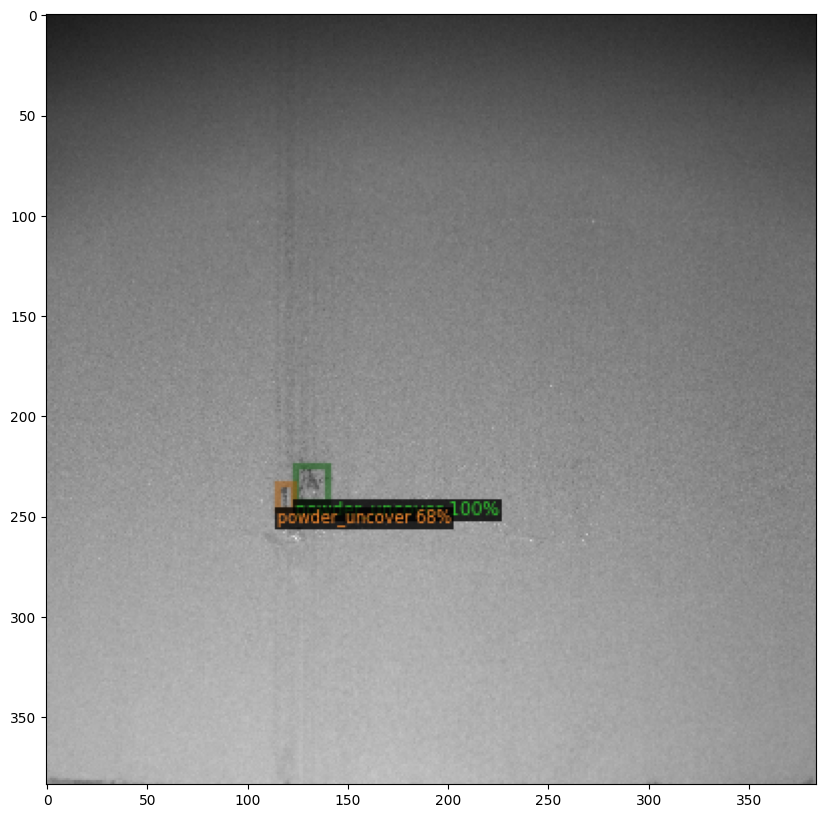

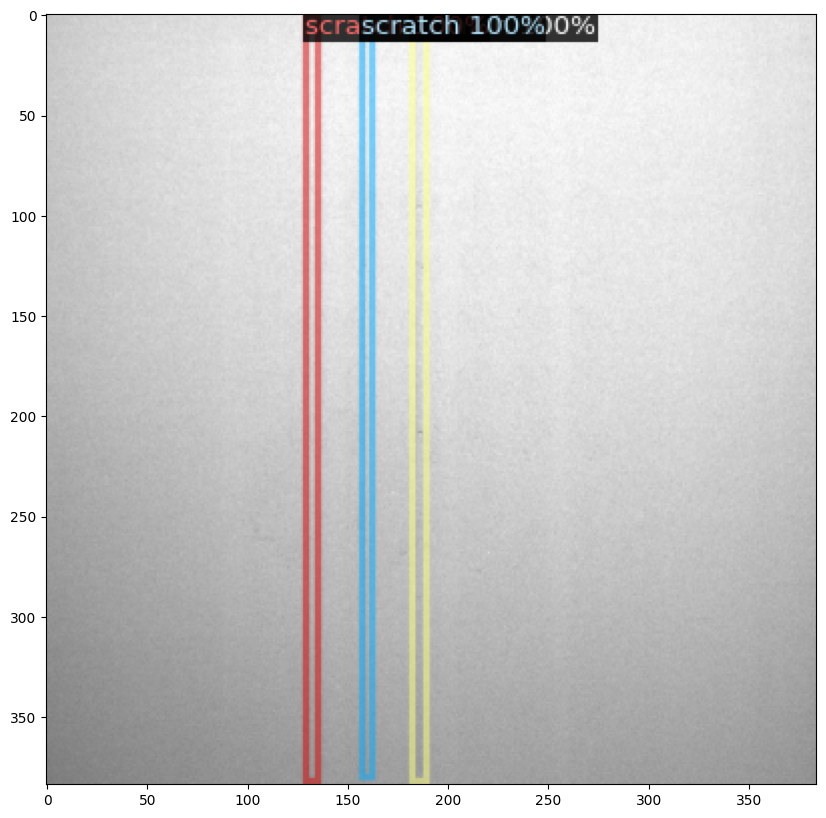

In [22]:
for d in random.sample(test_dataset_dicts, 2):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    filename = d["file_name"]
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    

# GUI

In [64]:

import PySimpleGUI as sg
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from PIL import Image, ImageTk
import io
import os
import os.path


file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]

#config_file = r"None"
#ckpt_file = r"Please read your check point file"
#img_file = r"Please read your img path"
#image_files = r"Please read your img path"

# 建立 detectron2 的 predictor
#cfg = model_zoo.get_config('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
#cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
#cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/outputModels1/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

#predictor = DefaultPredictor(cfg)

file_types = [("JPEG (*.jpg)", "*.jpg"),
              ("All files (*.*)", "*.*")]
file_list_column = [
    [
        sg.Listbox(
            values=[], enable_events=True, size=(40, 30), key="-FILE LIST-"
        )
    ],
]
height, width = 360, 360
def main():
    
    layout = [
        #sg.VSeperator(),
		#[sg.Text('config file',size=(16,1)), sg.In(config_file,size=(80,1), key='config'), sg.FileBrowse(file_types=file_types)],
        #[sg.Text('model checkpoint',size=(16,1), auto_size_text=False), sg.In(ckpt_file,size=(80,1), key='ckpt'), sg.FileBrowse(file_types=file_types)],
		#[sg.Text('Path to image',size=(16,1)), sg.In(img_file,size=(80,1), key='image'), sg.FileBrowse(file_types=file_types),sg.Button("Load Image"),],
        
        [
        sg.Text("Image Folder"),
        sg.In(size=(80, 1), enable_events=True, key="-FOLDER-"),
        sg.FolderBrowse('瀏覽'),
        ],
		[sg.Text('Device',size=(10,1)), sg.Combo(['cuda:0','cpu'],default_value='cpu',key='device')],
        [sg.Text(size=(40, 1), key="-TOUT-")],
		[sg.Text("File list",size=(10,1)),sg.Text("Source Image",size=(50,1)),sg.Text("Detected Image",size=(65,1))],
        [sg.Column(file_list_column), sg.Image(key="source_image",size=(height,width),background_color='white'),
        sg.Image(key="detected_image",size=(height,width),background_color='white')],
        [sg.Button('Detect'), sg.Exit()],
        [sg.Text('IOU',size=(4,1)),  sg.In(size=(100,1), key='iou')],
        [sg.Text('AP50',size=(4,1)),  sg.In(size=(100,1), key='ap')],
        [sg.Text('Dice',size=(4,1)),  sg.In(size=(100,1), key='dice')],
        [sg.Text('FPS',size=(4,1)),  sg.In(size=(100,1), key='fps')]
        ]
    window = sg.Window('detectron2', 
                   layout,
                   default_element_size=(14,2),
                   text_justification='right',
                   auto_size_text=False
                   # element_justification='c'
                   )

    while True:
        event, values = window.read()

        if event == "Exit" or event == sg.WIN_CLOSED:
            break

        if event == "-FOLDER-":
            folder = values["-FOLDER-"]
            try:
                file_list = os.listdir(folder)
            except:
                file_list = []

            fnames = [
                f
                for f in file_list
                if os.path.isfile(os.path.join(folder, f))
                and f.lower().endswith((".png", ".gif"))
            ]
            window["-FILE LIST-"].update(fnames)
        elif event == "-FILE LIST-":  
            try:
                filename = os.path.join(
                    values["-FOLDER-"], values["-FILE LIST-"][0]
                )
                print(filename)
                image = Image.open(filename)
                image.thumbnail((400, 400))
                bio = io.BytesIO()
                # Actually store the image in memory in binary 
                image.save(bio, format="PNG")
                # Use that image data in order to 
                window["source_image"].update(data=bio.getvalue())
            except:
                pass


        if event == "Load Image":
            
            filename = values["image"]
            image_name = os.path.basename(filename)
            if os.path.exists(filename):
                image = Image.open(values["image"])
                image.thumbnail((400, 400))
                bio = io.BytesIO()
                # Actually store the image in memory in binary 
                image.save(bio, format="PNG")
                # Use that image data in order to 
                window["source_image"].update(data=bio.getvalue())

        if event == "image":
            file_path = values["image"]
            img = cv2.imread(file_path)
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
            img_bytes = cv2.imencode(".png", img)[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            window["source_image"].update(data=img_bytes)

            
        if event == "Detect":
            filename = os.path.join(
                    values["-FOLDER-"], values["-FILE LIST-"][0]
                )
            # 使用 detectron2 偵測物件
            #filename = values["image"]
            label_path = filename.replace("image", "label")
            

        
            cfg = model_zoo.get_config('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
            cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
            cfg.MODEL.WEIGHTS = "/Users/david/Desktop/DIP_final/outputModels1/model_final.pth"
            cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
            # 使用 detectron2 偵測圖片中的物體
            img = cv2.imread(filename)
            img = cv2.resize(img,(400,400))
            iou_num = IOU_file(label_path[:-3] + 'json')
            print(label_path[:-3] + 'json')
            outputs = predictor(img)
            v = Visualizer(img[:, :, ::-1],
                        metadata=microcontroller_metadata, 
                        scale=1, 
                        instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # 將圖片轉換成 PySimpleGUI 可以顯示的格式
    
            img_bytes = cv2.imencode(".png", v.get_image())[1].tobytes()
            # 將圖片顯示在 PySimpleGUI 的視窗中
            window["iou"].update(iou_num)
            window["ap"].update(ap50['bbox']['AP50'])
            window["detected_image"].update(data=img_bytes)

            
    window.close()


if __name__ == "__main__":

    main()


2023-01-09 12:59:07.857 python[28132:4601779] +[CATransaction synchronize] called within transaction
2023-01-09 12:59:07.916 python[28132:4601779] +[CATransaction synchronize] called within transaction


/Users/david/Desktop/DIP_final/class_data/Try/gui_test/image/Converted_ 0003.png
/Users/david/Desktop/DIP_final/class_data/Try/gui_test/label/Converted_ 0003.json
/Users/david/Desktop/DIP_final/class_data/Try/gui_test/image/Converted_ 0006.png
/Users/david/Desktop/DIP_final/class_data/Try/gui_test/label/Converted_ 0006.json


In [24]:
print(1)

1
